In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc, rcParams
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
from functools import reduce
import operator
sys.path.append(os.path.relpath("../src"))
from kitaev_chain import kitaev_chain_model, quench_simulation, U
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import gamma_n
rcParams.update({ "text.usetex": True, "font.family": "serif", "text.latex.preamble": r"\usepackage{amsmath}" })

In [2]:
def fermion_chain_from_spin_chain_params_parrallel_field(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J; t[0] = t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)
def fermion_chain_from_spin_chain_params(n, J, h_z, h_edges_x):
    mu = np.ones(n) * h_z
    t = np.ones(n - 1) * J
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, False)

def are_bdg_conj(state1, state2):
    l = len(state1) // 2
    return np.allclose(np.abs(state1[[list(range(l, 2 * l)) + list(range(l))]] @ state2), np.ones(1))


In [3]:
n = 25
m = n + 2
H0 = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=200)
H = fermion_chain_from_spin_chain_params_parrallel_field(n, 1, 1, h_edges_x=0)
H0.bdg_eigen()
H.bdg_eigen()
u = U(H)
G_D = gamma_n(m).conj().T
[i for (i, v) in enumerate([are_bdg_conj(H0.bdg_evecs_sorted[:, i], H0.bdg_evecs_sorted[:, i + m]) for i in range(m)]) if not v]

[0]

In [4]:
high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, 2 * m - 2,2 * m - 1]]
if are_bdg_conj(H0.bdg_evecs_sorted[:, m - 2], H0.bdg_evecs_sorted[:, 2 * m - 1]):
    high_energy_states = H0.bdg_evecs_sorted[:,[m - 2, m - 1, 2 * m - 1,2 * m - 2]]

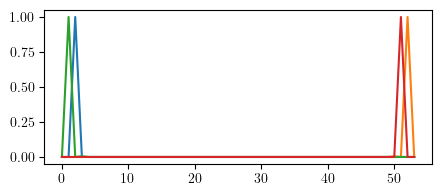

In [5]:

high_energy_maj = 0.5 ** 0.5 * np.hstack(
    [high_energy_states[:, :2] + high_energy_states[:, 2:],
     1j * (high_energy_states[:, :2] - high_energy_states[:, 2:])])
plt.gcf().set_size_inches((5,2))
for line in (G_D@(high_energy_maj)).T:
    plt.plot(np.abs(line))


In [6]:
cycle = 1.92 * m
duration = 9 * cycle
dt = m / 10
t_range = np.arange(0, duration, dt)

gamma_sim = [
    np.vstack([G_D@(u(t) @
                    maj
                    ) for t in t_range]).T
for maj in high_energy_maj.T
]

loschmidt_sim = np.array([np.abs(
            np.linalg.det(
                H0.bdg_evecs_sorted[:, :m].T.conj() @ u(t) @ H0.bdg_evecs_sorted[:, :m]
                )
            ) for t in t_range])



In [7]:
gamma_sim_ = [gamma_sim[i] for i in [2, 0, 3, 1]]
color = np.array([
    [0, 0.5, 1],
    [1, 0, 0],
    [0, 1, 0],
    [0.9, 0.6, 0]
    ])

image = np.permute_dims(
    (
        reduce(
            operator.mul,
               [
                   np.ones((3, *tuple(np.shape(gamma_sim_[i])))) -
                   np.kron(
                       (np.ones(3) - color[i]).reshape((3, 1, 1)),
                       np.abs(gamma_sim_[i])
                    )
                    for i in range(4)])),
    (1,2,0))
image = image[1:-1,:,:]

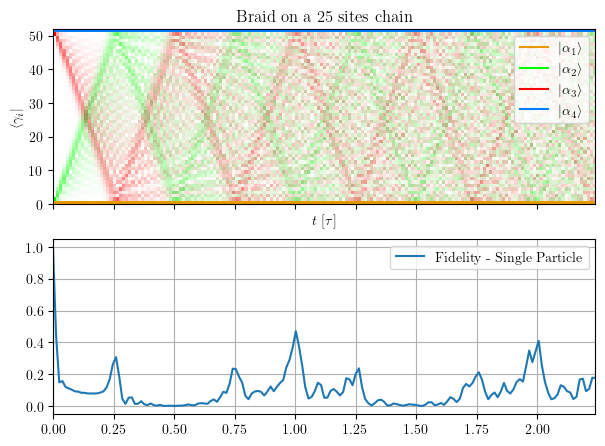

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(7, 5)
t_range_ = t_range / cycle / 4
xmin, xmax = t_range_[0], t_range_[-1]
color = color[::-1]
ax1.imshow(image, aspect='auto', interpolation='nearest', extent=(xmin, xmax, 0, image.shape[0]), origin='upper')
for i in range(4):
    ax1.plot([],[],color=color[i],label='$|\\alpha_'+f'{i+1}'+'\\rangle$')
ax1.legend()
ax1.set_ylabel("$\\langle\\gamma_i|$")
ax2.plot(t_range_, np.abs(loschmidt_sim), label="Fidelity - Single Particle")
ax2.legend()
ax2.grid()
ax2.set_xlim(xmin, xmax)
ax1.set_xlabel('$t \\ [\\tau]$')
ax1.set_title(f"Braid on a {n} sites chain")
plt.savefig(f"../simulations/braid on {n} sites chain.png")
pass